In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from sklearn.datasets import load_diabetes, load_wine
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fastloocv import FastLOOCV
from knn import Knn

# Since working with distances algorithms we will use scaling techniques
scaler = StandardScaler()

####################################################################################################
####################################################################################################
					 DIABETES DATASET
Size: 442
LOOCV:
Best k: 18, Score: 3209.0427350427344
time: 3.1757688522338867s
---------------------------------------------
Fast LOOCV:
Best k: 18, Score: 3209.0427350427353
time: 0.043189048767089844s


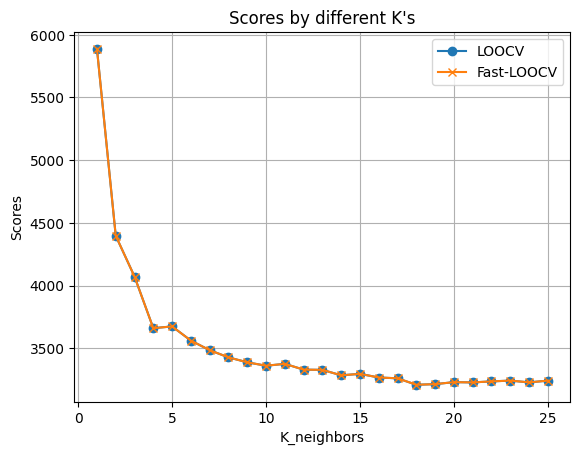

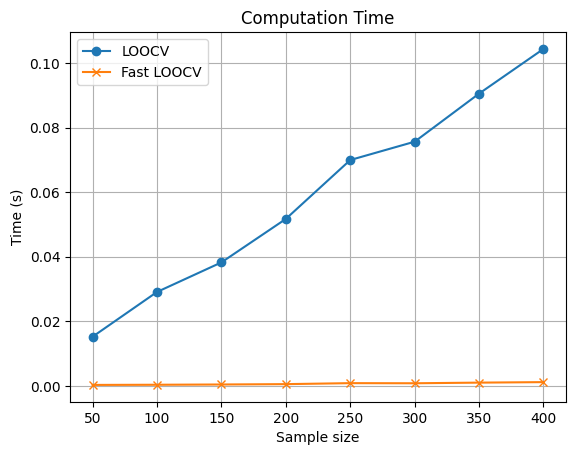

####################################################################################################
####################################################################################################


In [55]:
print("#"*100)
print("#"*100)
print("\t"*5, "DIABETES DATASET")

data = load_diabetes()
data.data = scaler.fit_transform(data.data)
print(f"Size: {len(data['data'])}")

model = FastLOOCV(data)
k_values = [k for k in range(1, 26)]

scores, time = model.do_normal_loocv(k_values=k_values, sample_size=None)
scores2, time2 = model.do_fast_loocv(k_values=k_values, sample_size=None)


print("LOOCV:")
print(f"Best k: {k_values[np.argmin(scores)]}, Score: {scores[np.argmin(scores)]}")
print(f"time: {time}s")
print("---"*15)
print("Fast LOOCV:")
print(f"Best k: {k_values[np.argmin(scores2)]}, Score: {scores2[np.argmin(scores2)]}")
print(f"time: {time2}s")

plt.plot(k_values, scores, marker='o', linestyle='-', label='LOOCV')
plt.plot(k_values, scores2, marker='x', label='Fast-LOOCV')

plt.xticks(np.arange(0, 30, 5))
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y') 
plt.title("Scores by different K's")
plt.xlabel("K_neighbors")
plt.legend()

plt.ylabel("Scores")
plt.show()

size = np.arange(50,420,50)
times = []
k = [5]
for s in size: 
    scores, time = model.do_normal_loocv(k_values=k, sample_size=s)
    scores2, time2 = model.do_fast_loocv(k_values=k, sample_size=s)
    times.append((time, time2))

plt.plot(size, [time[0] for time in times], marker='o', label='LOOCV')
plt.plot(size, [time[1] for time in times], marker='x', label='Fast LOOCV')
plt.title("Computation Time")
plt.xlabel("Sample size")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()
plt.show()

print("#"*100)
print("#"*100)

####################################################################################################
####################################################################################################
					 WINE DATASET
Size: 178
LOOCV:
Best k: 11, Score: 0.027811310242362358
time: 1.1327130794525146s
---------------------------------------------
Fast LOOCV:
Best k: 11, Score: 0.027811310242362323
time: 0.015851974487304688s


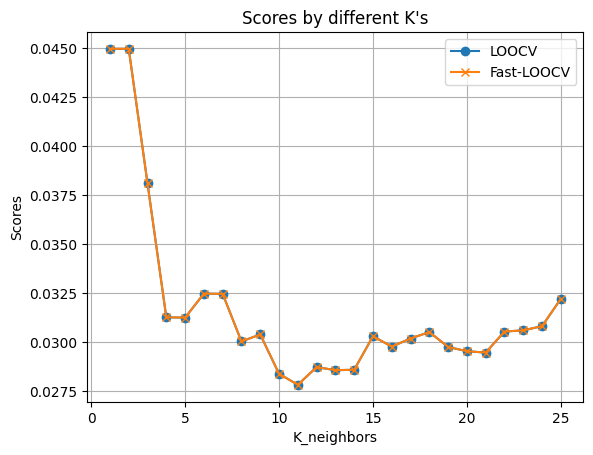

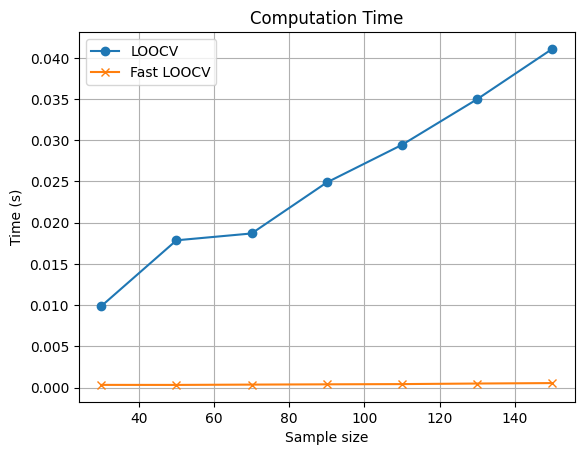

####################################################################################################
####################################################################################################


In [56]:
print("#"*100)
print("#"*100)
print("\t"*5,"WINE DATASET")

data =  load_wine()

data.data = scaler.fit_transform(data.data)
print(f"Size: {len(data['data'])}")

model = FastLOOCV(data)
k_values = [k for k in range(1, 26)]

scores, time = model.do_normal_loocv(k_values=k_values, sample_size=None)
scores2, time2 = model.do_fast_loocv(k_values=k_values, sample_size=None)


print("LOOCV:")
print(f"Best k: {k_values[np.argmin(scores)]}, Score: {scores[np.argmin(scores)]}")
print(f"time: {time}s")
print("---"*15)
print("Fast LOOCV:")
print(f"Best k: {k_values[np.argmin(scores2)]}, Score: {scores2[np.argmin(scores2)]}")
print(f"time: {time2}s")

plt.plot(k_values, scores, marker='o', linestyle='-', label='LOOCV')
plt.plot(k_values, scores2, marker='x', label='Fast-LOOCV')

plt.xticks(np.arange(0, 30, 5))
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y') 
plt.title("Scores by different K's")
plt.xlabel("K_neighbors")
plt.legend()

plt.ylabel("Scores")
plt.show()

size = np.arange(30,170,20)
times = []
k = [5]
for s in size: 
    scores, time = model.do_normal_loocv(k_values=k, sample_size=s)
    scores2, time2 = model.do_fast_loocv(k_values=k, sample_size=s)
    times.append((time, time2))

plt.plot(size, [time[0] for time in times], marker='o', label='LOOCV')
plt.plot(size, [time[1] for time in times], marker='x', label='Fast LOOCV')
plt.title("Computation Time")
plt.xlabel("Sample size")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()
plt.show()

print("#"*100)
print("#"*100)

(2392, 14)
Chosen the following variables: ['Absences', 'ParentalSupport', 'StudyTimeWeekly', 'Tutoring']


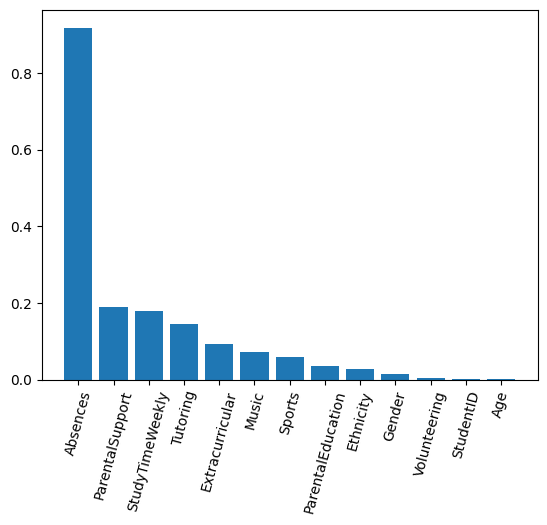

In [ ]:
# We read the dataset previusly downloaded from kaggle
# Url: https://doi.org/10.34740/KAGGLE/DS/5195702 the dataset was renamed as performance

df = pd.read_csv('data/performance.csv')
df.drop(['GradeClass'], axis=1, inplace=True)
print(df.shape)

# Build a correlation matrix and keep only out target to analyze which variables could help our regressor
correlation = abs(df.corr()["GPA"]).sort_values(ascending=False).drop(index=['GPA'])
plt.bar((correlation.index), correlation.values)
plt.xticks(rotation=75)

# Keep only variables with correlation greater than 10%
important_variables = correlation[correlation >= 0.1]
print(f"Chosen the following variables: {important_variables.index.to_list()}")

new_df = df[['GPA'] + important_variables.index.to_list()].copy()

# Adapting GPA to french grading
new_df['GPA'] = new_df['GPA'].astype(float) * 5

X = new_df.drop(columns=['GPA'])
y = new_df['GPA']
X_scaled = scaler.fit_transform(X.values) 

data = {'data': X_scaled,
        'target': y}

In [58]:
# We use F-LOOCV to find the optimal k for our problem
k_values = [k for k in range(1, 50)]
model = FastLOOCV(data)

scores, times  = model.do_fast_loocv(k_values=k_values, sample_size=None)
print(f"The best k found during training is: {k_values[np.argmin(scores)]}")

The best k found during training is: 15


In [59]:
print("--"*30)
print("Evaluating the model & Visualizing predictions and real values")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.15, random_state=42
)

knn = KNeighborsRegressor(n_neighbors=k_values[np.argmin(scores)])
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

knn2 = Knn(num_neighbors=k_values[np.argmin(scores)], p=2)
knn2.fit(X_train, y_train)
y_pred2 = knn2.predict(X_test)
mse2 = mean_squared_error(y_test, y_pred2)
r22 = r2_score(y_test, y_pred2)
print(f"MSE2: {mse2:.2f}")
print(f"R²2: {r22:.2f}")


------------------------------------------------------------
Evaluating the model & Visualizing predictions and real values
MSE: 1.88
R²: 0.91
MSE2: 1.88
R²2: 0.91


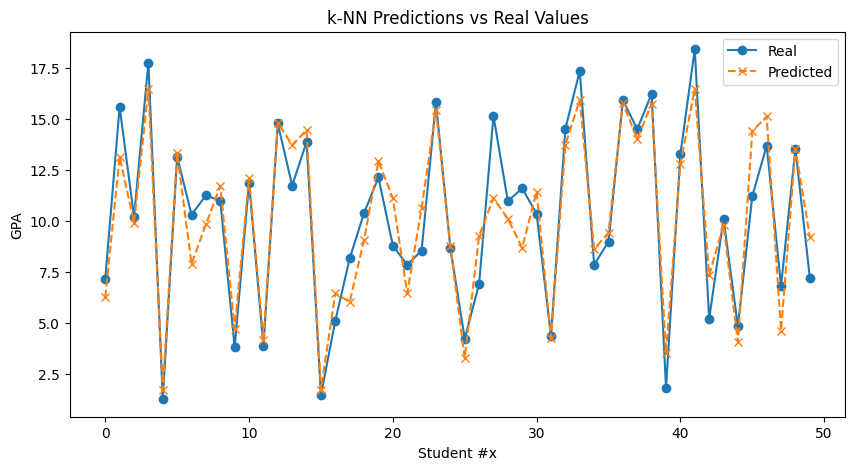

In [61]:

x_axis = list(range(len(y_pred)))
visualize_num = 50

plt.figure(figsize=(10,5))

plt.plot(x_axis[:visualize_num], y_test[:visualize_num], marker='o', label='Real')
plt.plot(x_axis[:visualize_num], y_pred[:visualize_num], marker='x', label='Predicted', linestyle='--')

plt.xlabel('Student #x')
plt.ylabel('GPA')
plt.title('k-NN Predictions vs Real Values')
plt.legend()
plt.show()

In [69]:
# 'Absences', 'ParentalSupport', 'StudyTimeWeekly', 'Tutoring'
knn = KNeighborsRegressor(n_neighbors=k_values[np.argmin(scores)])
knn.fit(data["data"], data["target"])

print("Playing with the model:")
while True:
    study_per_week = int(input("How many hours did you study per week"))
    absences = int(input("How many times you have been absent"))
    tutoring = int(input("Do you have tutoring (0:no 1:yes)"))
    p_support = int(input("How much support you have from your parents (0low, 4 high)"))
    features = scaler.transform([[absences, p_support, study_per_week, tutoring]])
    y = knn.predict(features)[0]
    print(f"Your expected grade s: {round(y, 2)}/20")
    x = input("Press e to exit or whatever to continue")
    if x == 'e':
        break

    

Playing with the model:
Your expected grade s: 17.87/20


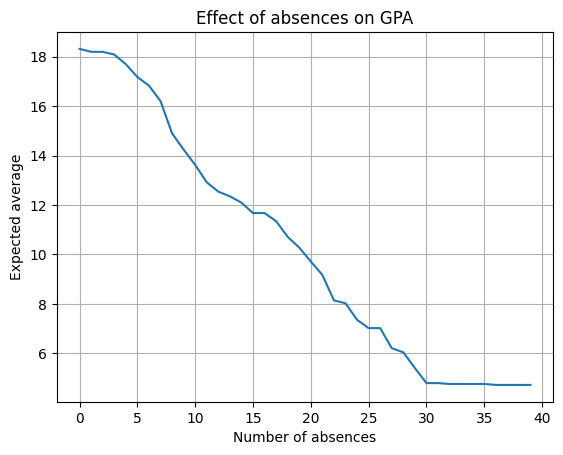

In [74]:
absences = [x for x in range(40)]
study = 10
tutoring = 1
p_support = 4

preds = list()
for absence in absences:
    features = scaler.transform([[absence, p_support, study, tutoring]])
    preds.append(knn.predict(features)[0])

plt.plot(absences, preds)
plt.grid(True)
plt.xlabel("Number of absences")
plt.ylabel("Expected average")
plt.title("Effect of absences on GPA")
plt.show()